In [1]:
import sys
sys.path.append('../')

import numpy as np
import random
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo
from gp_mjo.utils.dat_ops import dics_divide

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(train_x, train_y, model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


def predict(model, likelihood, test_x = torch.linspace(0, 1, 50)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def plot(train_x, train_y, observed_pred, test_x=torch.linspace(0, 1, 50)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

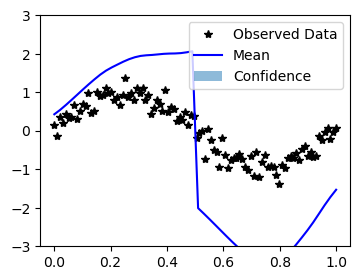

In [121]:
from gp_mjo.kernels.additive_matern import MaternAdditiveKernel
from gp_mjo.kernels.additive_matern_period import CustomAdditiveKernel
# Use the simplest form of GP model, exact inference
class FirstGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = gpytorch.kernels.ScaleKernel(MaternAdditiveKernel(lengthscale_unique = True))
        #self.covar_module = gpytorch.kernels.ScaleKernel(CustomAdditiveKernel(lengthscale_unique = True))
        self.covar_module = gpytorch.kernels.ScaleKernel(CustomBlockKernel(nu=1.5, num_paras = 1, para_upper=1.2))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

from gpytorch.constraints import Positive
from gpytorch.constraints import Interval
from gpytorch.functions import MaternCovariance
class CustomBlockKernel(gpytorch.kernels.Kernel):
    is_stationary = True # the custom kernel is stationary
    has_lengthscale = True
    
    # register the parameter when initializing the kernel
    def __init__(self, nu=0.5, num_paras = 2, para_upper=2.0,
                 #block_kernel=gpytorch.kernels.MaternKernel(nu=0.5),
                 paras_prior=None, paras_constraint=None,
                 **kwargs):
        #self.block_kernel = block_kernel
        self.nu = nu
        super().__init__(**kwargs)
        
        # register the raw parameter
        self.register_parameter(
                name='raw_paras', parameter=torch.nn.Parameter( torch.zeros(*self.batch_shape, num_paras))
        )
        
        if paras_constraint is None:
            paras_constraint = Interval( torch.zeros(num_paras), para_upper*torch.ones(num_paras) )

        # register the constraint
        self.register_constraint('raw_paras', paras_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if paras_prior is not None:
            self.register_prior(
                "paras_prior",
                paras_prior,
                lambda m: m.paras,
                lambda m, v : m._set_paras(v),
            )
    
    # now set up the 'actual' paramter
    @property
    def paras(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_paras_constraint.transform(self.raw_paras)

    @paras.setter
    def paras(self, value):
        return self._set_paras(value)

    def _set_paras(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_paras)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_paras=self.raw_paras_constraint.inverse_transform(value))
    
    # this is the kernel function
    def forward(self, x1, x2, alpha=None, diag=False, **params):
        
        if x1.dim() == 1 or x1.shape[0]==1:
            x1 = x1.reshape(-1,1)
        if x2.dim() == 1 or x2.shape[0]==1:
            x2 = x2.reshape(-1,1)
        
        n1 = x1.shape[0] // 2
        n2 = x2.shape[0] // 2

        x1_front = x1[:n1, :]
        x1_back = x1[n1:, :]

        x2_front = x2[:n2, :]
        x2_back = x2[n2:, :]

        if alpha is None:
            alpha = self.paras[0]

        #K22 = self.block_kernel.forward(x1=x1_back,x2=x2_back, diag=diag, **params) # n1 * n2 matrix
        K22 = MaternCovariance.apply(
            x1_back, x2_back, self.lengthscale, self.nu, lambda x1, x2: self.covar_dist(x1, x2, **params)
        ) # n1 * n2 matrix
        B1 = alpha * torch.eye(n1) # n1 * n1 matrix
        B2 = alpha * torch.eye(n2) # n2 * n2 matrix
        K12 = B1 @ K22 # n1 * n2 matrix
        K21 = K22 @ B2.T # n1 * n2 matrix

        K12_cond = MaternCovariance.apply(
            x1_front, x2_front, self.lengthscale, self.nu, lambda x1, x2: self.covar_dist(x1, x2, **params)
        )# n1 * n2 matrix
        K11 = K12_cond + K12 @ B2.T # n1 * n2 matrix

        K = torch.cat( (torch.cat((K11,K12),dim=1), torch.cat((K21,K22),dim=1)), dim=0) # 2(n1) * 2(n2) matrix

        return K


# ## generate training data from sampling
# n = 100
# train_x = torch.linspace(0, 1, n)

# A = CustomBlockKernel(nu=0.5, num_paras = 1, para_upper=10.0).forward(x1=train_x,x2=train_x, alpha=15.4)
# L = torch.linalg.cholesky(A)
# train_y = L @ torch.normal(0.0, 1.0, size=(n,1))
# train_y = train_y.reshape(-1).detach()

# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = FirstGPModel(train_x, train_y, likelihood)

# # set to training mode and train
# model.train()
# likelihood.train()
# train(train_x, train_y, model, likelihood)


n = 100
train_x = torch.linspace(0, 1, n)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
test_x = torch.linspace(0, 1, 50)


########################################################
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = FirstGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(train_x, train_y, model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood, test_x = test_x)
# plot results
plot(train_x, train_y, observed_pred, test_x=test_x)

In [122]:
print(model.covar_module.base_kernel.paras)
print(model.covar_module.base_kernel.lengthscale)

tensor([0.0213], grad_fn=<AddBackward0>)
tensor([[0.3131]], grad_fn=<SoftplusBackward0>)


In [29]:
for name, param in model.state_dict().items():
    print(name)
    print(param)

likelihood.noise_covar.raw_noise
tensor([-4.3741])
likelihood.noise_covar.raw_noise_constraint.lower_bound
tensor(1.0000e-04)
likelihood.noise_covar.raw_noise_constraint.upper_bound
tensor(inf)
mean_module.raw_constant
tensor(0.9956)
covar_module.raw_outputscale
tensor(2.6233)
covar_module.base_kernel.raw_lengthscale
tensor([[0.0536]])
covar_module.base_kernel.raw_paras
tensor([3.7243])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound
tensor(0.)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound
tensor(inf)
covar_module.base_kernel.raw_paras_constraint.lower_bound
tensor([0.])
covar_module.base_kernel.raw_paras_constraint.upper_bound
tensor([2.])
covar_module.raw_outputscale_constraint.lower_bound
tensor(0.)
covar_module.raw_outputscale_constraint.upper_bound
tensor(inf)


In [30]:
model.covar_module.base_kernel.paras

tensor([1.9529], grad_fn=<AddBackward0>)

In [83]:
model.covar_module.base_kernel.lengthscale.detach().numpy()

array([[0.45371905]], dtype=float32)

In [56]:
model.covar_module.base_kernel.weights.detach().numpy() / model.covar_module.base_kernel.weights.detach().numpy().sum()

array([0.00643699, 0.49981543, 0.46990523, 0.02384236], dtype=float32)

In [46]:
model.covar_module.base_kernel.lengthscales.detach().numpy()

array([0.6931472, 0.6931472, 0.6931472, 0.6931472], dtype=float32)

In [21]:
model.covar_module.period_length

tensor([0.6931], grad_fn=<SoftplusBackward0>)

In [72]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)

data_names = npzfile.files
n_files = len(npzfile.files)

new_datas = [0]*n_files
for i in range(n_files):
    new_datas[i] = npzfile[data_names[i]]

In [ ]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = True

n = 10000 # the number of days for training
m = 160 # the number of days for testing
c = 365 # the number of dropped buffer set

n_cv = 1 # the number of operations for cross-validation
n1s  = [random.randint(0,n) for i in range(n_cv)]


palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
plot_colors = palette_colors[:len(widths)]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=0.5) + gpytorch.kernels.MaternKernel(nu=1.5) \
    + gpytorch.kernels.MaternKernel(nu=2.5)#gpytorch.kernels.PeriodicKernel() 

In [ ]:
x1 = torch.randn(50, 2)
k=kernel(x1)

In [ ]:
print(gpytorch.kernels.MaternKernel(nu=nu)(x1).__getitem__(0))
print(gpytorch.kernels.PeriodicKernel()(x1).__getitem__(0))
print(k.__getitem__(0))

In [ ]:
## Independent RMMs
dics_total = {}
for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total[n1] = dics
    for width, color in zip(widths, plot_colors):
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        for i in range(4):  # data_names = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
            data_name = data_names[3:][i]
            # initialize plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 8))            
            
            if i <= 1:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name)
            if i == 2:
                mjo_model.rmm_to_phase()
            if i == 3:
                mjo_model.rmm_to_amplitude()
            mjo_model.plot_mjo(data_name, ax, color)

            ax.set_title(f'GP Inference for MJO {data_name}, width = {width}, $n_1$ = {n1} with Independent RMMs',fontsize=14)
            plt.show()